Pairs Trading Analysis: A Cointegration and Kalman Filter Approach

Author: Katleho Makatjane (Dr)
Department of Statistics, University of Botswana

Method 1: Cointegration Approach

In [19]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from pykalman import KalmanFilter

In [9]:
# Define the list of stock symbols
symbols = ["KO", "PEP"]
# Fetch historical stock data
stock_data = yf.download(stock_symbols, start="2019-01-01", end="2024-01-18", progress=False)
# Extract the 'Close' prices from the fetched data
closing_prices = stock_data["Close"]

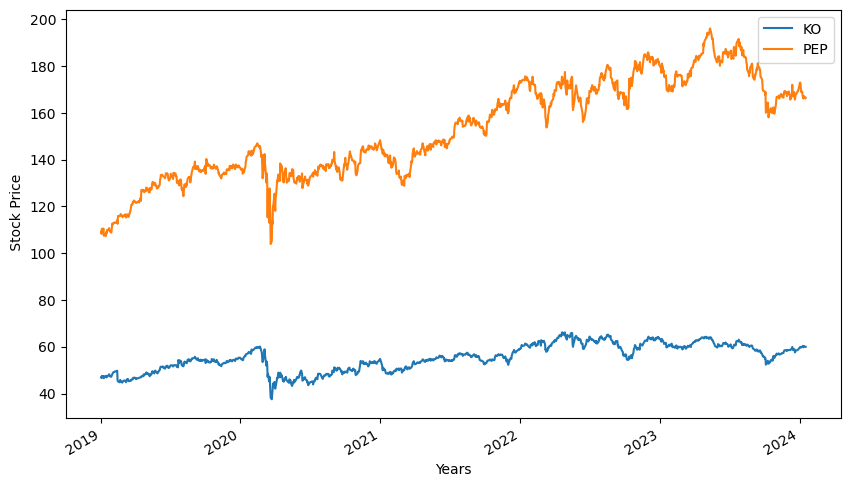

In [10]:
# Plot the closing prices
closing_prices.plot(figsize=(10, 6))
plt.title("")
plt.xlabel("Years")
plt.ylabel(" Stock Price")
plt.legend(stock_symbols)
plt.grid(False)
plt.show()

In [11]:
Hlompho = np.log(closing_prices)
print(Hlompho)

                  KO       PEP
Date                          
2019-01-02  3.848657  4.693913
2019-01-03  3.842459  4.684536
2019-01-04  3.862202  4.704835
2019-01-07  3.849083  4.696198
2019-01-08  3.860309  4.705739
...              ...       ...
2024-01-10  4.097672  5.117515
2024-01-11  4.091173  5.112771
2024-01-12  4.100824  5.119609
2024-01-16  4.094178  5.113011
2024-01-17  4.094178  5.114635

[1269 rows x 2 columns]


Step 2: Estimate Spreads
If we have two stocks, X and Y, which are cointegrated in their price movements, then any divergence in the spread from 0 should be temporary and mean-reverting. Next step we will estimate the spread series.

In [12]:
# Run linear regression over two log price series
x = list(np.log(Hlompho[symbols[0]]))
x_const = sm.add_constant(x)
y = list(np.log(Hlompho[symbols[1]]))
linear_reg = sm.OLS(y,x_const)
results = linear_reg.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     4418.
Date:                Sat, 20 Jan 2024   Prob (F-statistic):               0.00
Time:                        07:48:00   Log-Likelihood:                 3692.2
No. Observations:                1269   AIC:                            -7380.
Df Residuals:                    1267   BIC:                            -7370.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3184      0.019     16.343      0.000       0.280       0.357
x1             0.9328      0.014     66.470      0.000       0.905       0.960
==============================================================================
Omnibus:                       45.914   Durbin-Watson:                   0.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.224
Skew:                          -0.393   Prob(JB):                     6.78e-10
Kurtosis:                       2.574   Cond. No.                         111.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
beta = results.params[1]
alpha = results.params[0]
y_pred = np.log(Hlompho[symbols[0]])*beta + alpha

C:\Users\katle\AppData\Local\Temp\ipykernel_7812\1558994407.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([str(p) for p in Hlompho[symbols[0]].index])


Text(0, 0.5, 'PEP')

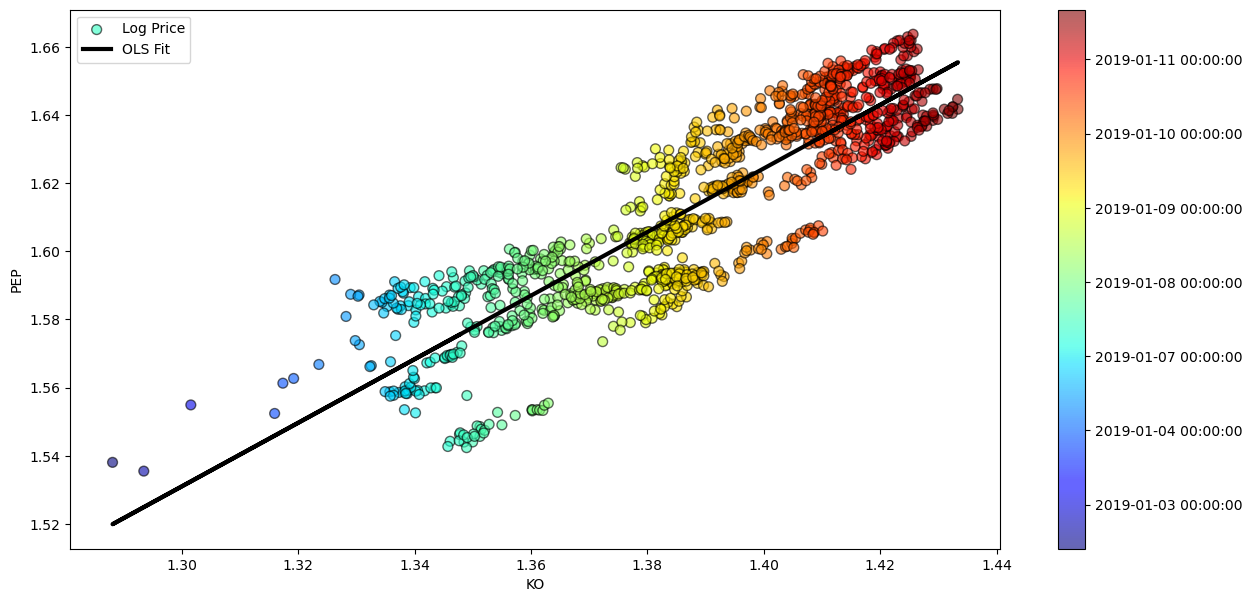

In [14]:
plt.figure(figsize =(15,7))
cm = plt.get_cmap('jet')
sc = plt.scatter(np.log(Hlompho[symbols[0]]), np.log(Hlompho[symbols[1]]), s=50, c=x, cmap=cm, marker='o',
                 alpha=0.6,label='Log Price',edgecolor='k')
plt.plot(x, y_pred, '-',c='black',linewidth=3, label='OLS Fit')
plt.legend()
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p) for p in Hlompho[symbols[0]].index])
plt.xlabel(symbols[0])
plt.ylabel(symbols[1])

Text(0, 0.5, 'spread')

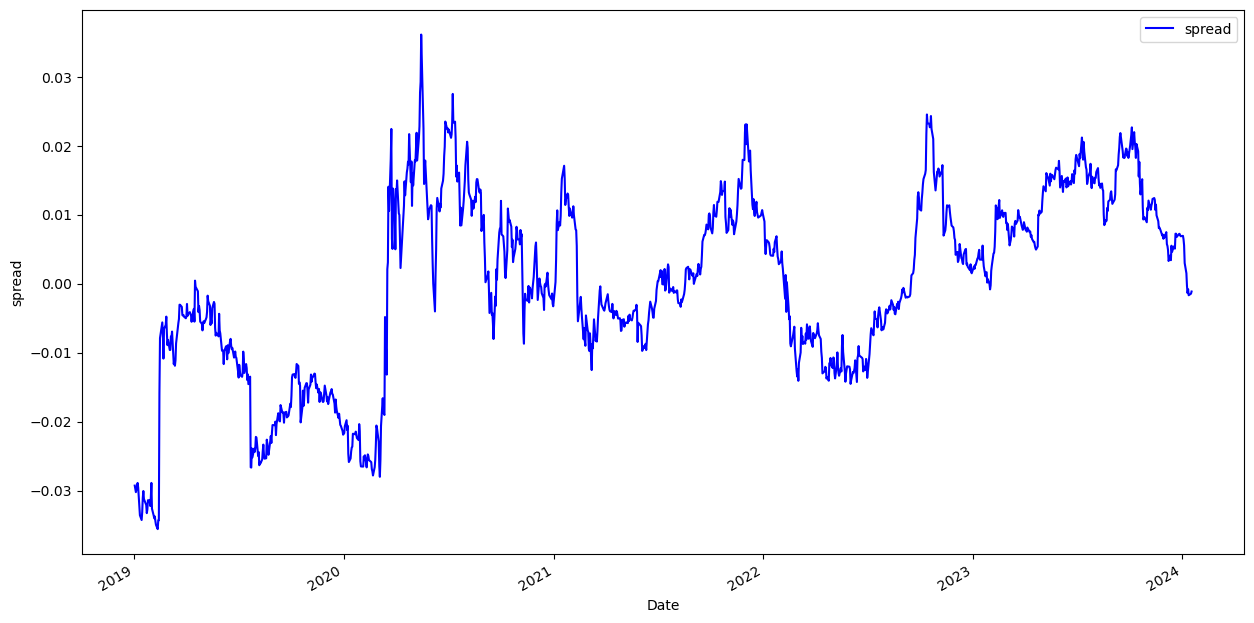

In [15]:
# construct the spread series according to OLS result
Makatjane= pd.DataFrame(np.log(Hlompho[symbols[1]]) - np.log(Hlompho[symbols[0]])*beta-alpha,index=Hlompho[symbols[0]].index)
Makatjane.columns = ['spread']
Makatjane.plot(figsize =(15,8), color='blue')
plt.ylabel('spread')

Step 3: Check Stationarity
From the above plot, the first order difference $Spred_{t} = \log(x_{t})-\beta \log(x_{t})-\alpha$ 

In [16]:
# check if the spread is stationary 
adf = sm.tsa.stattools.adfuller(Makatjane['spread'], maxlag=1)
print('ADF test statistic: %.02f' % adf[0])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))
print('p-value: %.03f' % adf[1])

ADF test statistic: -3.23
	1%: -3.436
	5%: -2.864
	10%: -2.568
p-value: 0.019


Running the example prints the test statistic value of -3.23. The more negative this statistic, the more likely we are to reject the null hypothesis (there is a unit root). As part of the output, we get a table to help determine the ADF statistic. We can see that our statistic value of -3.23 is less than the value of -3.436 at 1%. The p-value 0.019 is less than 0.05. This suggests that we can reject the null hypothesis with a significance level of less than 1%. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

Step 4: Create Trading Signal
Here we use 1.96 times the standard deviation as our threshold. 1.96 is the approximate value of the 97.5 percentile point of the normal distribution. 95% of the area under a normal curve lies within roughly 1.96 standard deviations of the mean. If the sample is out of this range, then we think there is a price divergence between these two stocks price which means the pairs trading opportunity.

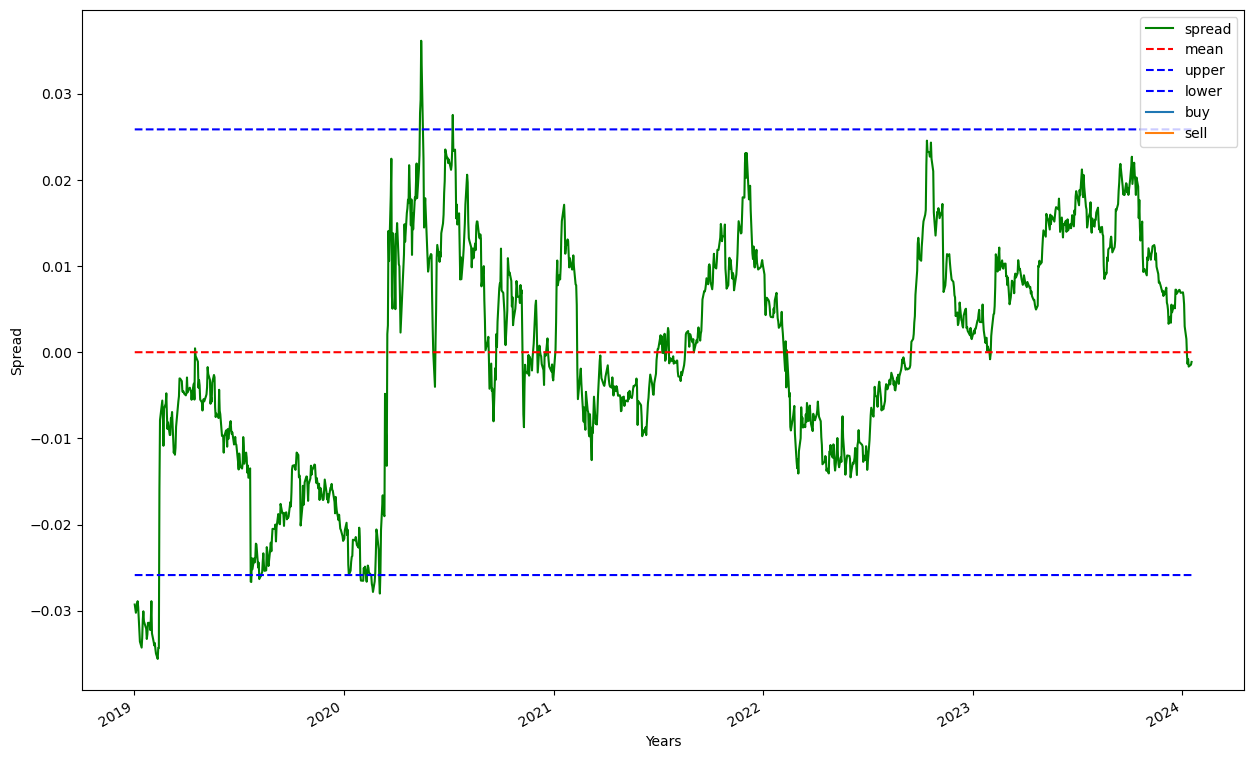

In [33]:
Makatjane['mean'] = Makatjane['spread'].mean()
Makatjane['upper'] = Makatjane['mean'] + 1.96*Makatjane['spread'].std()
Makatjane['lower'] = Makatjane['mean'] - 1.96*Makatjane['spread'].std()
Makatjane.plot(figsize =(15,10),style=['g', '--r', '--b', '--b'])
plt.ylabel('Spread')
plt.xlabel('Years')
plt.title('')
plt.legend(loc='best')
plt.show()

<Axes: xlabel='Date'>

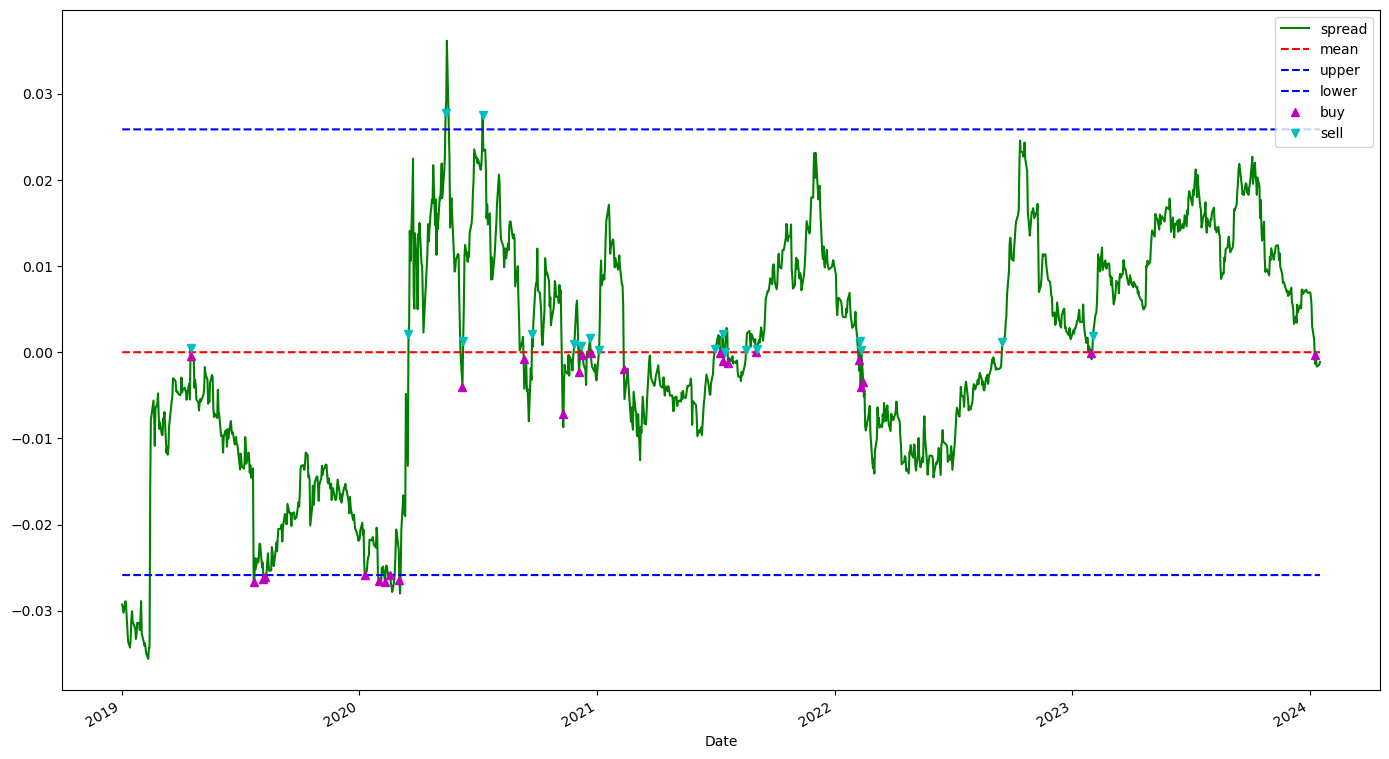

In [34]:
Makatjane['buy'] = Makatjane['spread'][((Makatjane['spread'] < Makatjane['lower']) & (Makatjane['spread'].shift(1) > Makatjane['lower']) | 
                          (Makatjane['spread'] <  Makatjane['mean']) & (Makatjane['spread'].shift(1) >  Makatjane['mean']))]

Makatjane['sell'] = Makatjane['spread'][((Makatjane['spread'] > Makatjane['upper']) & (Makatjane['spread'].shift(1) < Makatjane['upper']) | 
                           (Makatjane['spread'] >  Makatjane['mean']) & (Makatjane['spread'].shift(1) <  Makatjane['mean']))]
Makatjane.plot(figsize =(17,10), style=['g', '--r', '--b', '--b', 'm^','cv'])

Here buying the spread means buy 1 unit of stock B(KO) and sell $\beta$ units of stock A (PEP). We expect that the relationship between x and y will hold in the future. Buying the spread when it is lower than the standard deviation $\sigma$ and closing out the position when it returns to mean $\mu$. Selling the spread means to sell 1 unit of stock B(PEP) and buy  units of stock A(KO) and when it is above $\sigma$ and close the position when reaching the long-term mean to realize a profit.

Method: Kalman Filter

If we use linear regression to estimate those two parameters for the spread calculation, the main issue is that we have to pick an arbitrary lookback window and assume in the near future they will still keep this relationship and the spread will convergence to its long-term equilibrium. But in practice, $\alpha$ and $\beta$ are not constants and they vary over time. This means that they are not market observables. On the other hand, the long-term relationship can break down.

In the following codes, I use Kalman filter to model the spread. This is an adaptive filter which updates itself iteratively and produces $\alpha$, $\beta$ dynamically. I use the python package pykalman which has the EM method that calibrates the covariance matrices over the training period. For the model details https://www.quantstart.com/articles/Dynamic-Hedge-Ratio-Between-ETF-Pairs-Using-the-Kalman-Filter

In [20]:
obs_mat = sm.add_constant(np.log(Hlompho[symbols[0]]).values, prepend=False)[:, np.newaxis]
trans_cov = 1e-5 / (1 - 1e-5) * np.eye(2)

In [21]:
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, 
                  initial_state_mean=np.ones(2),
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=0.5,
                  transition_covariance=0.000001 * np.eye(2))

Text(0, 0.5, 'intercept')

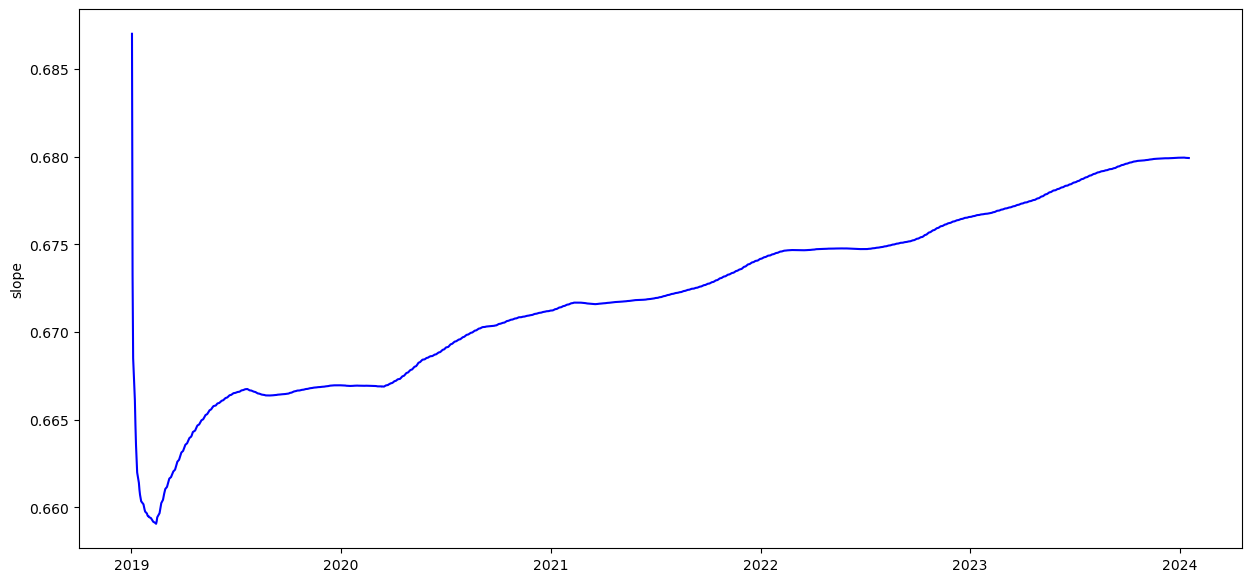

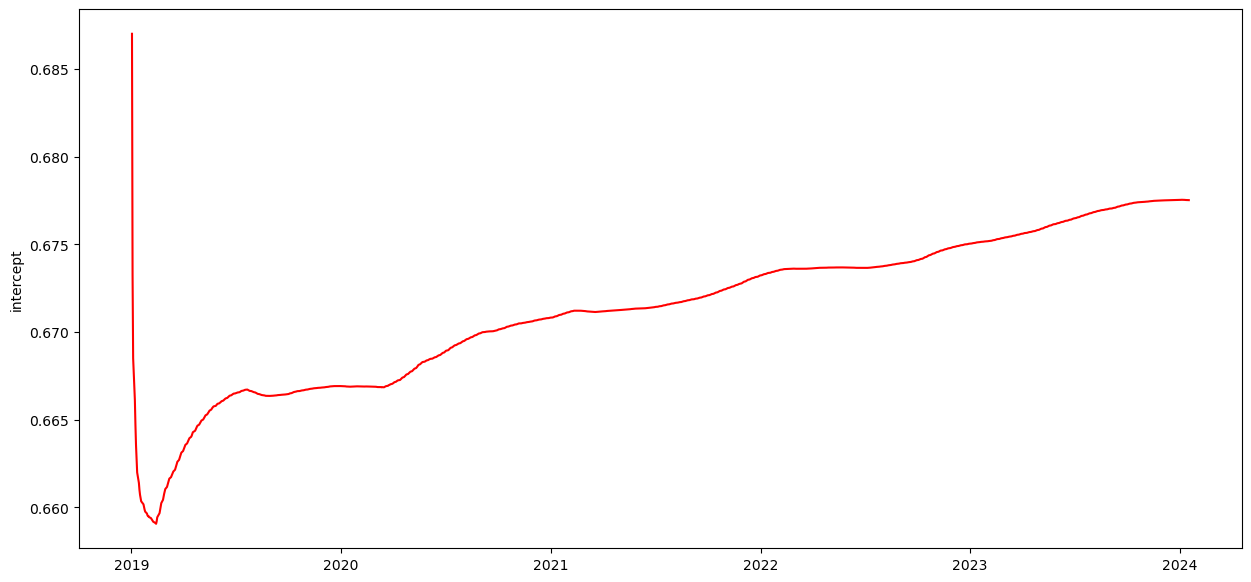

In [23]:
state_means, state_covs = kf.filter(np.log(Hlompho[symbols[1]]).values)
slope=state_means[:, 0] 
intercept=state_means[:, 1]
plt.figure(figsize =(15,7))
plt.plot(Hlompho[symbols[1]].index, slope, c='b')
plt.ylabel('slope')
plt.figure(figsize =(15,7))
plt.plot(Hlompho[symbols[1]].index,intercept,c='r')
plt.ylabel('intercept')

From the result above, the slope increases and the intercept doesn't change too much as the time goes.

C:\Users\katle\AppData\Local\Temp\ipykernel_7812\2573412964.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([str(p) for p in Hlompho[symbols[0]].index])


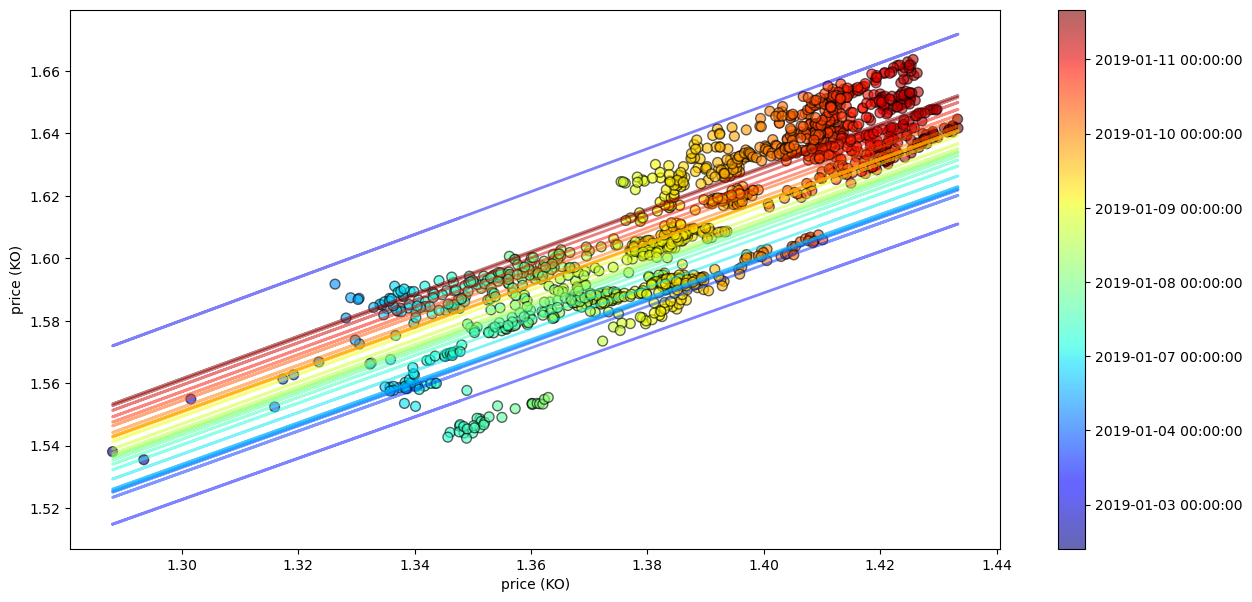

In [25]:
# visualize the correlation between assest prices over time
plt.figure(figsize =(15,7))
cm = plt.get_cmap('jet')
sc = plt.scatter(np.log(Hlompho[symbols[0]]), np.log(Hlompho[symbols[1]]), s=50, c=x, cmap=cm, marker='o',
                 alpha=0.6,label='Price',edgecolor='k')
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p) for p in Hlompho[symbols[0]].index])
plt.xlabel("price (%s)" %symbols[0])
plt.ylabel("price (%s)" %symbols[0])

# add regression lines
step = 50 # pick slope and intercept every 50 days
colors_l = np.linspace(0.1, 1, len(state_means[::step]))
for i, b in enumerate(state_means[::step]):
    plt.plot(np.log(Hlompho[symbols[0]]), b[0] *np.log(Hlompho[symbols[0]]) + b[1], alpha=.5, lw=2, c=cm(colors_l[i]))

Next I plot the original spread and the spread estimated using Kalman Filter.

C:\Users\katle\AppData\Local\Temp\ipykernel_7812\2236446125.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  Katleho = Makatjane.drop(['buy','sell'],1)


Text(0.5, 0, 'Years')

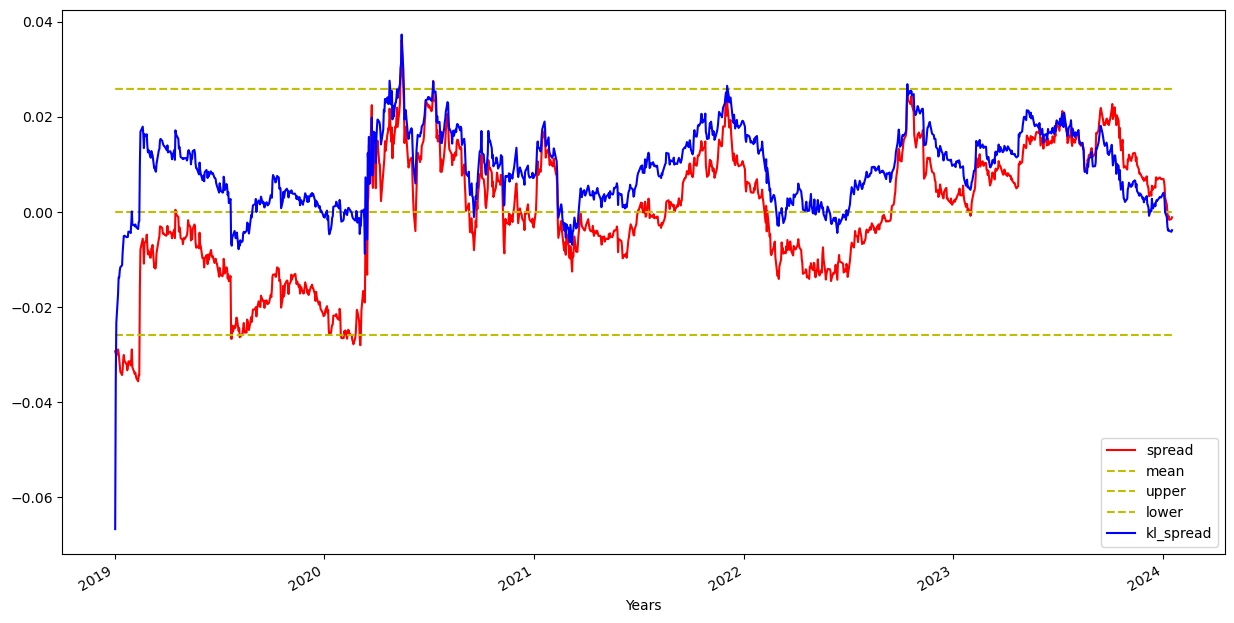

In [37]:
kl_spread = np.log(Hlompho[symbols[1]]) - np.log(Hlompho[symbols[0]]) * state_means[:,0] - state_means[:,1]
Makatjane['kl_spread'] = kl_spread
Katleho = Makatjane.drop(['buy','sell'],1)
Katleho.plot(figsize =(15,8),style=['r','--y', '--y', '--y','b'])
plt.xlabel('Years')

Text(0.5, 0, 'Years')

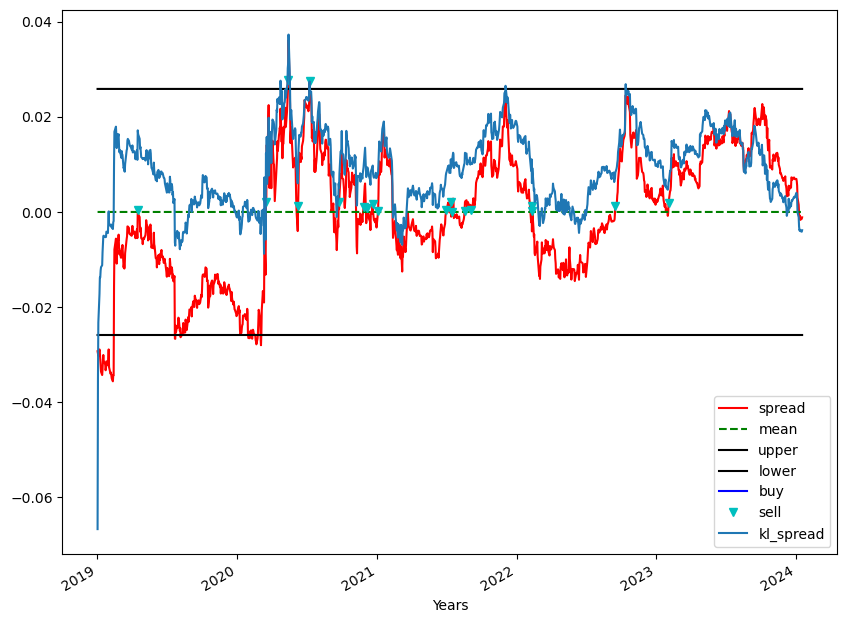

In [59]:
kl_spread = np.log(Hlompho[symbols[1]]) - np.log(Hlompho[symbols[0]]) * state_means[:,0] - state_means[:,1]
Makatjane['kl_spread'] = kl_spread
Makatjane.plot(figsize =(10,8),style=['r','--g', '-k', '-k','b','cv'])

plt.xlabel('Years')